In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import torch.optim as optim
from torch.autograd import Variable
from torch.optim import lr_scheduler
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [0]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch

In [5]:
train_data = datasets.MNIST('~/data/fmnist/', train=True, transform=transforms.ToTensor(), download=True)
test_data = datasets.MNIST('~/data/fmnist/', train=False, transform=transforms.ToTensor(), download=True)
data_loader = torch.utils.data.DataLoader(train_data, batch_size=128, 
            shuffle=True, num_workers=4, drop_last=True)

Processing...
Done!


In [0]:
def view_samples(samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples):
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    plt.show()
    return fig, axes

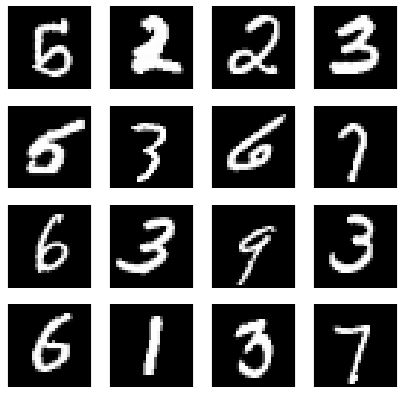

In [7]:
############### Viewing 16 random images from MNIST training set #############
ind = np.random.choice(len(train_data), 16)
samples = []
for i in ind:
  samples.append(train_data[i][0].numpy())
_ = view_samples(np.array(samples).transpose(0,2,3,1))

In [0]:
class Params():
  def __init__(self):
    self.Nz = 100
    self.alpha = 0.1
    self.beta1 = 0.5
    self.beta2 = 0.999
    self.lr = 0.002
    self.epochs = 25
    self.batch_size = 128
    self.out_dim = 1

params = Params()
  

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    self.network = nn.Sequential(
      nn.ConvTranspose2d(params.Nz, 512, 3,
                         stride=1, padding = 0, bias=False),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(params.alpha,True),
        
      nn.ConvTranspose2d(512, 256, 3,
                         stride=2, padding = 1, bias=False),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(params.alpha,True),
        
      nn.ConvTranspose2d(256, 128, 4,
                         stride=2, padding = 0, bias=False),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(params.alpha,True),
        
      nn.ConvTranspose2d(128, params.out_dim, 6,
                         stride=2, padding = 0, bias=False),
      nn.Tanh()
    )
  def forward(self, z):
    return self.network(z)

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    
    
    self.network1 = nn.Sequential(
      nn.Conv2d(1, 128, 5,
                stride=2, padding=0, bias=False),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(params.alpha,True),
        
      nn.Conv2d(128, 256, 5,
          stride=2, padding=0, bias=False),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(params.alpha,True),
        
      nn.Conv2d(256, 512, 3,
          stride=3, padding=0, bias=False),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(params.alpha,True)
    )
        
    self.cl = nn.Sequential(
      nn.Linear(512,1, bias=False),
      nn.Sigmoid()
    )
    
    
  def forward(self, input):
    x = self.network1(input)
    x = self.cl(x.squeeze())
    return x.view(-1,1).squeeze(1)

In [0]:
def kaiming_normal_init(m):
  if isinstance(m, nn.Conv2d):
    nn.init.kaiming_normal(m.weight)
  elif isinstance(m, nn.Linear):
    nn.init.kaiming_normal(m.weight)

In [0]:
def train(data_loader):
  gen = Generator().cuda()
  dis = Discriminator().cuda()
  gen.apply(kaiming_normal_init)
  dis.apply(kaiming_normal_init)
  criterion = nn.BCELoss()
  
  z = torch.randn(params.batch_size, params.Nz, 1, 1)
  
  optimizer_gen = optim.Adam(gen.parameters(), lr=params.lr,
                            betas=(params.beta1, params.beta2))
  optimizer_dis = optim.Adam(dis.parameters(), lr=params.lr,
                            betas=(params.beta1, params.beta2))
  
  ###### Training
  for epoch in range(params.epochs):
    print('Epoch {}/{}'.format(epoch, params.epochs-1))
    for i,data in enumerate(data_loader):
      images, _ = data
      images = Variable(images).cuda()
      labels = torch.ones(len(images))
      labels = Variable(labels).cuda()
      optimizer_dis.zero_grad()
      outputs = dis(images)
      
      loss_real = criterion(outputs, labels)
      
      random = Variable(z).cuda()
      outputs_fake = gen(random)
      # discriminator learns to discriminate generative samples from real samples
      # therefore they will try to say that generative samples are unreal
      labels = Variable(torch.zeros(len(images))).cuda()
      outputs_f_r = dis(outputs_fake)
      loss_fake = criterion(outputs_f_r, labels)
      
      loss_d = loss_real+loss_fake
      loss_d.backward(retain_graph=True)
      optimizer_dis.step()
      
      
      optimizer_gen.zero_grad()
      # generator learns to fool the discriminator so it will try to produce 
      # samples as close to real images
      labels = Variable(torch.ones(len(images))).cuda()
      outputs_fake_gen = dis(outputs_fake)
      loss_gen = criterion(outputs_fake_gen, labels)
      loss_gen.backward()
      optimizer_gen.step()
      
      ############### Viewing 16 random images from MNIST training set #############
      if ((epoch+1)%10 == 0 or epoch == 0) and i%100 == 0:
        print('dis loss: ', loss_d.data[0] , ' gen loss: ', loss_gen.data[0])
        ind = np.random.choice(len(data), 16)
        samples = []
        for i in ind:
          samples.append(outputs_fake[i].data.cpu().numpy())
        _ = view_samples(np.array(samples).transpose(0,2,3,1))
        
  return gen, dis
  
    
    
                       
                       
                    
      

Epoch 0/24
dis loss:  1.4644604921340942  gen loss:  0.8910394906997681


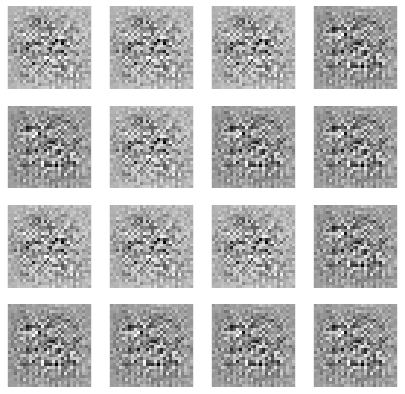

dis loss:  1.3320937156677246  gen loss:  0.8222844004631042


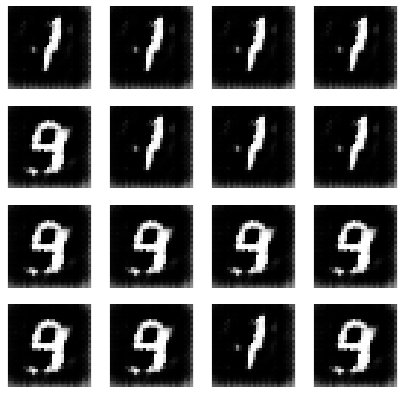

dis loss:  1.285406231880188  gen loss:  0.8876219987869263


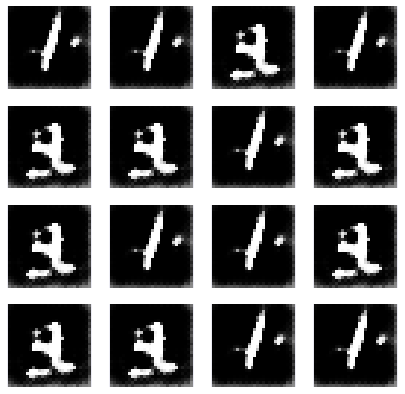

dis loss:  1.2958621978759766  gen loss:  0.8957979679107666


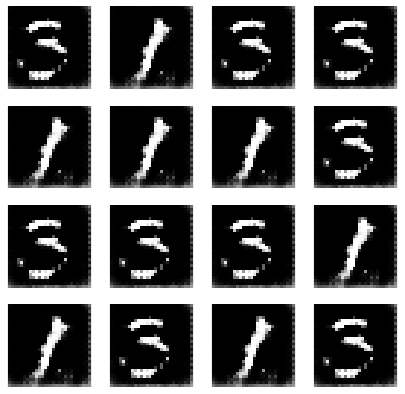

dis loss:  1.2861106395721436  gen loss:  0.9662609100341797


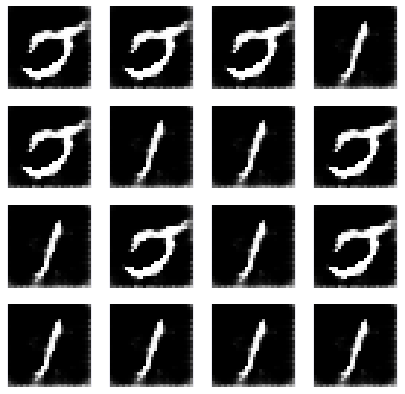

Epoch 1/24
Epoch 2/24
Epoch 3/24
Epoch 4/24
Epoch 5/24
Epoch 6/24
Epoch 7/24
Epoch 8/24
Epoch 9/24
dis loss:  1.0946210622787476  gen loss:  1.379759669303894


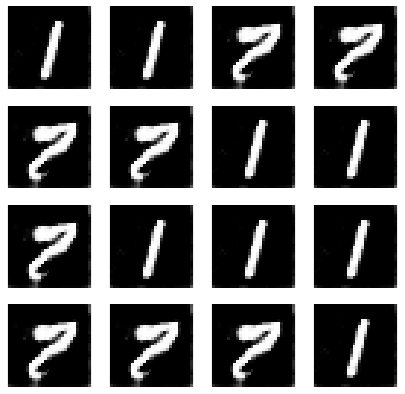

dis loss:  1.1326911449432373  gen loss:  1.400613784790039


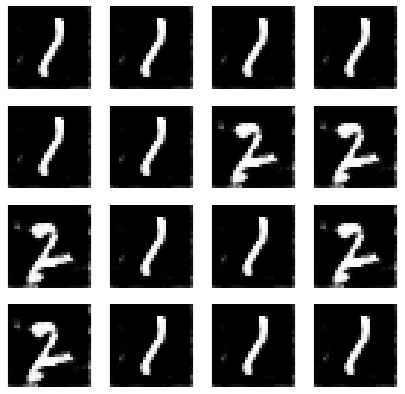

dis loss:  1.3127832412719727  gen loss:  0.9216141700744629


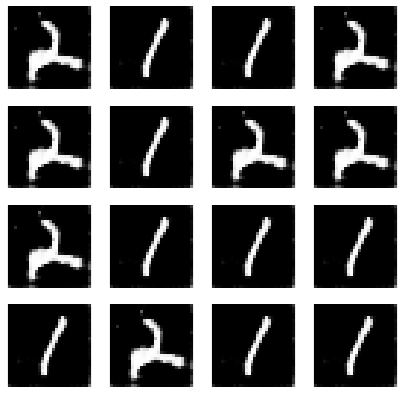

dis loss:  1.178394079208374  gen loss:  1.2828792333602905


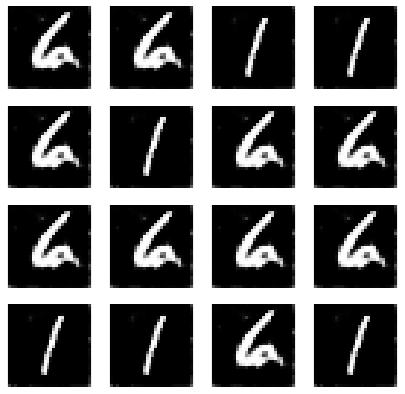

dis loss:  1.165540337562561  gen loss:  1.331251859664917


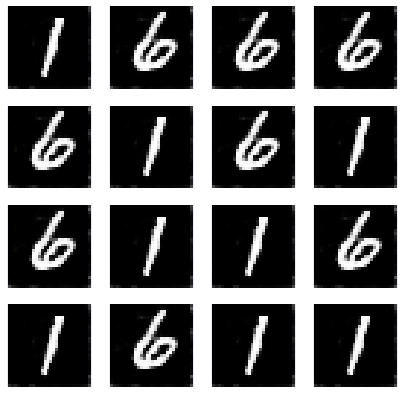

Epoch 10/24
Epoch 11/24
Epoch 12/24
Epoch 13/24
Epoch 14/24
Epoch 15/24
Epoch 16/24
Epoch 17/24
Epoch 18/24
Epoch 19/24
dis loss:  1.022230863571167  gen loss:  1.8157254457473755


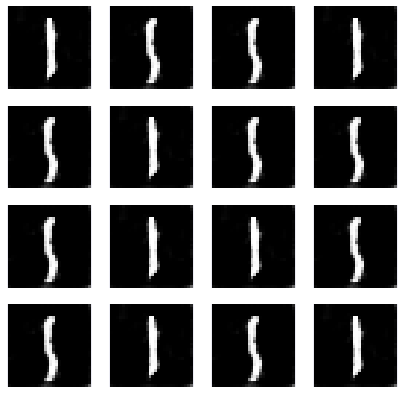

dis loss:  1.0078907012939453  gen loss:  1.3223414421081543


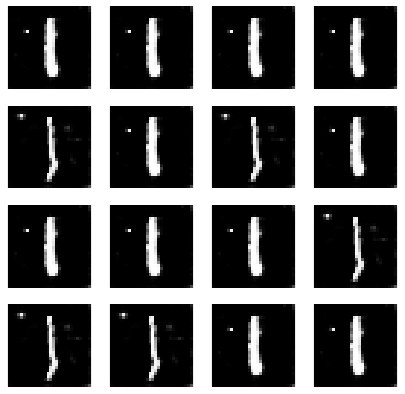

dis loss:  1.0389282703399658  gen loss:  1.4458024501800537


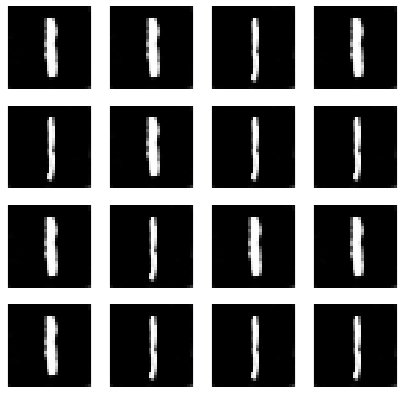

dis loss:  1.1237483024597168  gen loss:  1.7977427244186401


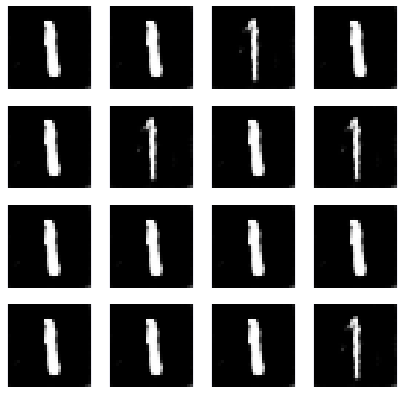

dis loss:  0.9143975377082825  gen loss:  1.468809962272644


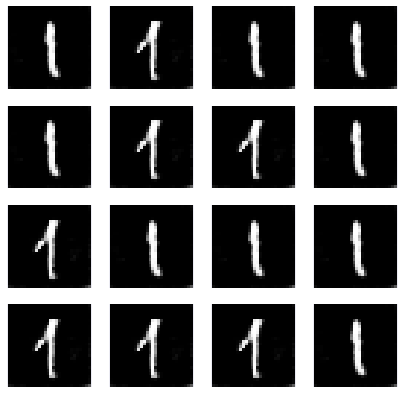

Epoch 20/24
Epoch 21/24
Epoch 22/24
Epoch 23/24
Epoch 24/24


In [13]:
gen,dis = train(data_loader)

In [0]:
for i,data in enumerate(data_loader):
  if i < 4:
    images, _ = data
    images = Variable(images).cuda()
    ind = np.random.choice(len(data), 16)
    samples, samples_gen = [], []
  #   for i in ind:
  #     samples.append(images[i].data.cpu().numpy())

  #   print('real image')

  #   _ = view_samples(np.array(samples).transpose(0,2,3,1))
    print('gen image')
    z = torch.randn(params.batch_size, params.Nz, 1, 1)
    out_gen = gen(Variable(z).cuda())
    for i in ind:
      samples_gen.append(out_gen[i].data.cpu().numpy())
    _ = view_samples(np.array(samples_gen).transpose(0,2,3,1))
    print('-----------------------------------------')
    
  
  